In [59]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji

stop_words = set(stopwords.words("english"))


In [60]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [61]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()

  # Replace emojis with text representation
  text = emoji.demojize(text).replace(':', ' ')

  # Remove stopwords
  tokens = [i for i in word_tokenize(text) if i not in stop_words]

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [62]:
cleanly_tokenize("Product was a cheap made material that cost 73.00.  I thought it was what I had on my bike. I searched again and found what I was looking for.  And this was cheaper and not only that it is a stronger  material.  😠😡😲 was not pleased at all!!!")

['product',
 'cheap',
 'made',
 'material',
 'cost',
 'thought',
 'bike',
 'searched',
 'found',
 'looking',
 'cheaper',
 'stronger',
 'material',
 'angry_face',
 'enraged_face',
 'astonished_face',
 'pleased']

In [63]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(["It worked for me. Now the chicks can't complain about a long antenna 😀",
       'Worked great!!! Wrapped my car with it 😍',
       'My son is a hockey player and he loves it so do I. Thanks so much.. 😀😀',
       "Very disappointed I bought this last July 11 and got it July 21installed it July 22 , 2015 in the morning tested it both light was working I went to work then to my dismay while driving home one of the bulb started flickering and when I reached home it's dead. The seller is ISSEC so it's one star but if they will replace just the the busted bulb ill update my review, the sad part is when I tried to look for it says not Available at this time. I will never purchased from this seller (ISSEC)😬😬😬",
       'A good product😊',
       'It wasnt what i expected.. 😞😭😡😠 only a pro can deal with it..',
       'Fit like a glove😁',
       'I love it very very much everything I hope it to be🙌🙌',
       "It's Menzerna and Menzerna is an automatic 5 stars! 😀 I layer my waxes/sealants t

In [64]:
def get_review_body(review_id):
  return cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0])

get_review_body("R1CKCTN2BXKOBQ")

['work', 'great', 'grinning_face', 'grinning_face']

In [65]:
trunc = data.sample(10000)
trunc['review_body'].head(10)

300857        Great winch, used to pull a CJ off the rocks.
187241    Im the only one around my hood with these. And...
226676    Excellent quality is the norm for Hella produc...
173667                                        Does the job.
301580               Fast service , perfect fit. Thank you.
185410                                     Very very yellow
158739    I finally decided to splurge and buy one of th...
115163    Seems to have solved my issue of coolant disap...
406859    It is a single, very flimsy sign which is bare...
46216                                           worked fine
Name: review_body, dtype: object

In [66]:
vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=3000
)

counts = vectorizer.fit_transform(trunc["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
print(words)

# print words that contain _ (emojis)
print([word for word in words if "_" in word])

df_tf_idf = pd.DataFrame(counts, columns=words)


c:\Users\stijn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\stijn\AppData\Local\Temp\ipykernel_10668\3211577921.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


['OK_hand' 'aaa' 'ab' ... 'zone' 'zvm' 'zx']
['OK_hand', 'thumbs_up']


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf, trunc["star_rating"], test_size=0.2)

# Create an SVM classifier
classifier = MultinomialNB(force_alpha=True) #KNeighborsClassifier() #SVC()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6935


In [68]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming X is your TF-IDF matrix and Y is the corresponding star ratings

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf, trunc["star_rating"], test_size=0.2)

# undersampler = RandomUnderSampler(sampling_strategy="all")
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and fit the logistic regression model with class weights
model = LogisticRegression(max_iter=10000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.71


In [69]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * len(X_test))


# Retrieve the corresponding sample and its information
sample_text = trunc.iloc[X_test.index[random_idx]]['review_body']
sample_tokenized = cleanly_tokenize(sample_text)
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: mounted these on the front of my bass boat and they work as good as i hoped they would i would suggest these flood lights for night time boating and much more they really light up the way
Tokenized Text: ['mounted', 'front', 'bass', 'boat', 'work', 'good', 'hoped', 'would', 'would', 'suggest', 'flood', 'light', 'night', 'time', 'boating', 'much', 'really', 'light', 'way']
Real Stars: 5
Predicted Stars: 5


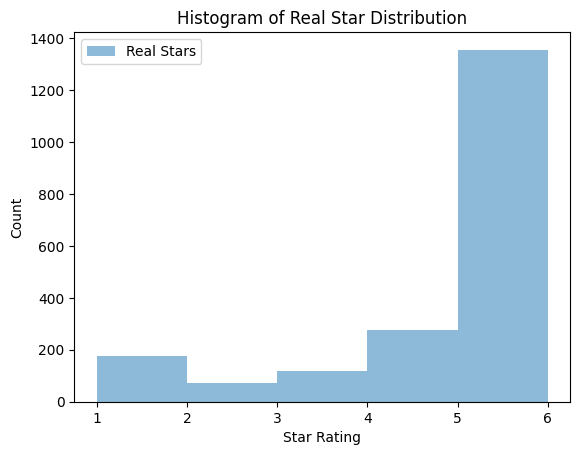

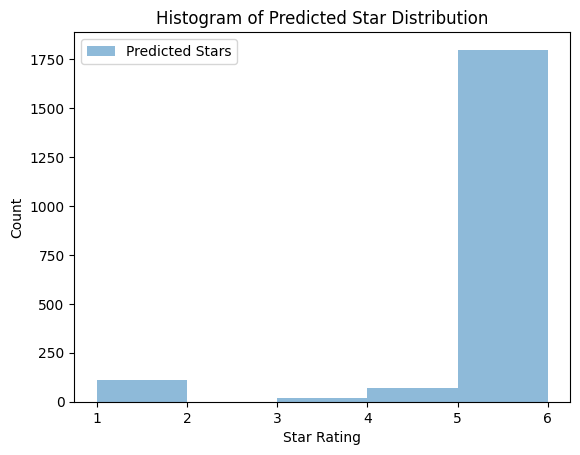

In [70]:
import matplotlib.pyplot as plt

# Plot the histogram of real star distribution
plt.hist(y_test, bins=5, range=(1, 6), alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=5, range=(1, 6), alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [71]:
print(len(y_test.loc[y_test == 1]))
print(len(y_test.loc[y_test == 2]))
print(len(y_test.loc[y_test == 3]))
print(len(y_test.loc[y_test == 4]))
print(len(y_test.loc[y_test == 5]))

176
72
119
278
1355


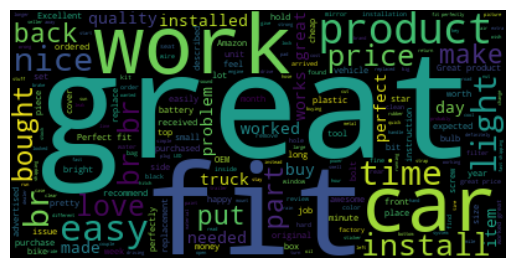

In [72]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

textt = " ".join(review for review in trunc['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [73]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\stijn\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [74]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [75]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))
